# Code for reproducing Normative theory in Figure 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#gridspec
import matplotlib.gridspec as gridspec
from scipy.linalg import eig
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
sys.path.append('..')
from cann import CANN1D

/home/zilong/anaconda3/envs/anticipative_track/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### set the hyper-parameters and functions

In [2]:
N = 128 #network size, i.e., number of place cells
M = 10 #truncate the number of eigenvalues, i.e., Fourier modes? 
epsilon = 1 #pertub strength, relating to the adaptation strength
offset = 10 #offset, relating to the distance between U bump and V bump

In [3]:
#generate a pertubation matrix with offset-th diagonal values equal to epsilon, other values are zero
def get_pertub_mat(N, epsilon, offset):
    '''
    get a circular matrix with offset-th diagonal values equal to epsilon, other values are zero
    N: int, the size of the matrix
    epsilon: float, the value of the offset-th diagonal
    offset: int, the offset of the diagonal
    '''
    pertub_mat = np.zeros((N, N))
    for i in range(N):
        if i+offset < N:
            pertub_mat[i, i+offset] = epsilon
        else:
            pertub_mat[i, i+offset-N] = epsilon
    return pertub_mat

def get_pertub_mat_4_visualization(N, epsilon, offset, width=5):
    '''
    get a circular matrix with offset-th diagonal values equal to epsilon, other values are zero
    N: int, the size of the matrix
    epsilon: float, the value of the offset-th diagonal
    offset: int, the offset of the diagonal
    '''
    pertub_mat = np.zeros((N, N))
    for i in range(N):
        if i+offset < N:
            pertub_mat[i, i+offset-width:i+offset+width] = epsilon
        else:
            pertub_mat[i, i+offset-width-N:i+offset+width-N] = epsilon
    return pertub_mat


## Section 1: plot perturbation matrix

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


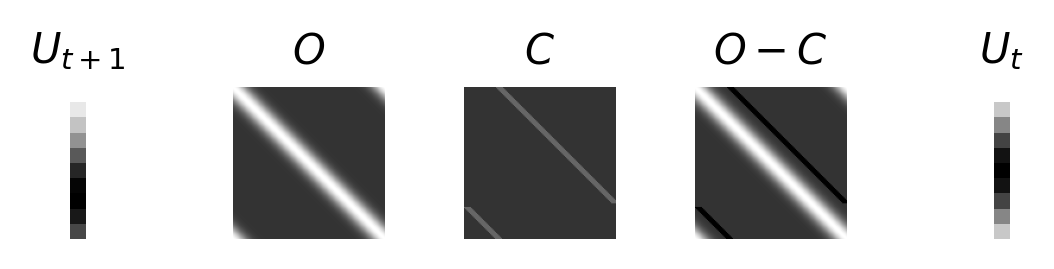

In [4]:
#get the connection matrix from the CANN, i.e., the generator
replay_cann = CANN1D(tau=1., tau_v=48., num=N, mbar=1.5)

weight_mat = np.zeros((N, N))
for i in range(N):
    weight_vec = replay_cann.make_conn_i(i)
    weight_mat[i,:] = weight_vec

offset = 30

fig = plt.figure(figsize=(4, 1), dpi=300)
labelsize = 10
ticksize = 8
#gridspec.GridSpec(2, 2)
gs = gridspec.GridSpec(1, 5)

#generate a M vector with Gaussian bump using numpy center at N/2
M=10
x = np.arange(M)
y = np.exp(-((x-M/1.5)**2)/(2*3**2))
y = y/np.sum(y)
y = 1-y
#plot the vector in the vertical way
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(y[:, np.newaxis], cmap='gray', vmin=np.min(y), vmax=np.max(y))
ax0.set_yticks([]); ax0.set_xticks([])
ax0.set_title(r"$U_{t+1}$", fontsize=labelsize)

#plot the connection matrix
ax1 = fig.add_subplot(gs[0, 1])
minval = np.min(weight_mat)
maxval = np.max(weight_mat)
ax1.imshow(weight_mat, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax1.set_yticks([]); ax1.set_xticks([])
ax1.set_title(r"$O$", fontsize=labelsize)

#plot the pertubation matrix 1
ax2 = fig.add_subplot(gs[0, 2])
pertub_mat_1 = get_pertub_mat_4_visualization(N, epsilon, offset, width=3)
ax2.imshow(pertub_mat_1, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax2.set_yticks([]); ax2.set_xticks([])
ax2.set_title(r"$C$", fontsize=labelsize)

#subtract the pertubation matrix 1 from the connection matrix and plot
ax3 = fig.add_subplot(gs[0, 3])
ax3.imshow(weight_mat-pertub_mat_1, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax3.set_yticks([]); ax3.set_xticks([])
ax3.set_title(r"$O-C$", fontsize=labelsize)

#generate a M vector with Gaussian bump using numpy center at N/2
x = np.arange(M)
y = np.exp(-((x-M/2)**2)/(2*3**2))
y = y/np.sum(y)
y = 1-y
#plot the vector in the vertical way
ax4 = fig.add_subplot(gs[0, 4])
ax4.imshow(y[:, np.newaxis], cmap='gray', vmin=np.min(y), vmax=np.max(y))
ax4.set_yticks([]); ax0.set_xticks([])
ax4.set_title(r"$U_{t}$", fontsize=labelsize)

#set axis off
for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.axis('off')

plt.tight_layout()

#save the figure
plt.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig3_pertubation_%d.pdf'%offset, dpi=300)

## Section 2: plot the egienvectors of the transition matrix

/tmp/ipykernel_1341293/2686874679.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  inset_ax3.plot(V_t, 'r-', color='#009FB9', label='V', linewidth=2)
/tmp/ipykernel_1341293/2686874679.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


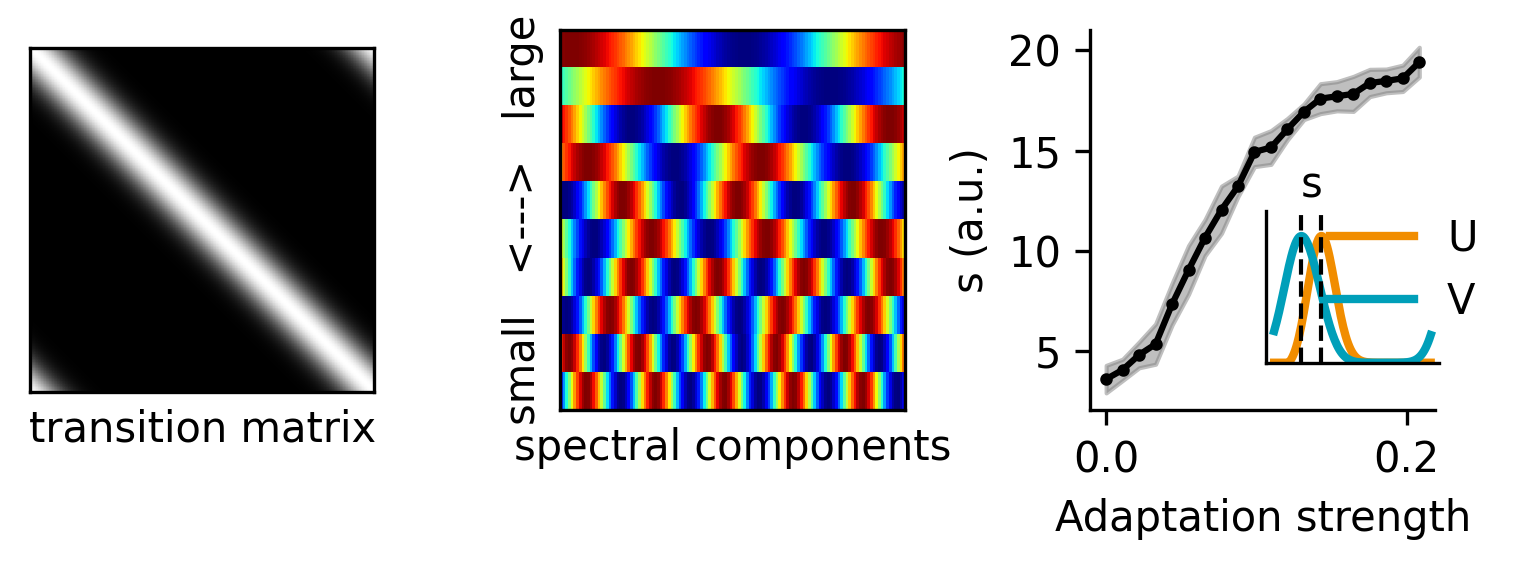

In [5]:
fig = plt.figure(figsize=(5, 2), dpi=300)
labelsize =10
ticksize = 8
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

#get the connection matrix from the CANN, i.e., the generator
replay_cann = CANN1D(tau=1., tau_v=48., num=N, mbar=1.5)

weight_mat = np.zeros((N, N))
for i in range(N):
    weight_vec = replay_cann.make_conn_i(i)
    weight_mat[i,:] = weight_vec
    
#eigendecomposition of the connection matrix
evals, evecs_l, evecs_r = eig(weight_mat, left=True, right=True)  

#plot the connection matrix
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(weight_mat, cmap='gray')
ax1.set_yticks([]); ax1.set_xticks([])
ax1.set_xlabel('transition matrix', fontsize=labelsize)
#add color bar to ax1
#cbar = plt.colorbar(ax1.imshow(weight_mat, cmap='gray'), ax=ax1, fraction=0.046, pad=0.04)

#plot the first M left eigenvectors without smoothing
#remove the first one 
ax2 = fig.add_subplot(gs[0, 1])
#imshow with the image as a squared one
ax2.imshow(evecs_l[:,1:M+1].T, cmap='jet', interpolation='none', aspect='auto')
ax2.set_yticks([]); ax2.set_xticks([])
#set ylabel as large <---> small
ax2.set_ylabel('small   <--->   large', fontsize=labelsize)
ax2.set_xlabel('spectral components', fontsize=labelsize)

#plot the relation between m and s
#load the adaptation strength, mean displacement and std displacement
data = np.load('../Data/Fig8_m_d.npz')
adaptation_stre = data['adaptation_stre']
mean_dp = data['mean_dp']
std_dp = data['std_dp']
ax3 = fig.add_subplot(gs[0, 2])

ax3.plot(adaptation_stre, mean_dp, 'o-', markersize=2, color='k', markerfacecolor='k')
ax3.fill_between(adaptation_stre, mean_dp-std_dp, mean_dp+std_dp, color='gray', alpha=0.5)
ax3.set_xlabel('Adaptation strength')
ax3.set_ylabel('s (a.u.)')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

inset_ax3 = inset_axes(ax3, width='50%', height='40%', loc="lower left", 
                      bbox_to_anchor=(0.45, 0.07, 1, 1), bbox_transform=ax3.transAxes)

UV_data = np.load("../Data/Fig8_U_V.npz")
U_t = UV_data['U_t']
V_t = UV_data['V_t']

U_t = U_t/np.max(U_t)
V_t = V_t/np.max(V_t)

inset_ax3.plot(U_t, '-', color='#F18D00', label='U', linewidth=2)
inset_ax3.plot(V_t, 'r-', color='#009FB9', label='V', linewidth=2)
inset_ax3.legend(frameon=False, bbox_to_anchor=(0.8, 1.2), loc='upper center', ncol=1)
inset_ax3.spines['top'].set_visible(False)
inset_ax3.spines['right'].set_visible(False)
inset_ax3.set_xticks([])
inset_ax3.set_yticks([])

U_peak = np.argmax(U_t)
V_peak = np.argmax(V_t)
inset_ax3.axvline(U_peak, color='k', linestyle='--', linewidth=1)
inset_ax3.axvline(V_peak, color='k', linestyle='--', linewidth=1)

inset_ax3.text((U_peak+V_peak)/2, 1.3, 's', ha='center', fontsize=labelsize)
inset_ax3.set_ylim([0, 1.2])

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig3_transitionmat_and_eigenvectoes.pdf', dpi=300)

## Section 3: generate super-diffusive pattern using oscillatory eigenvalues


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from cann import CANN1D
from tqdm import tqdm
from scipy.linalg import eig

#get the connection matrix from the CANN, i.e., the generator
def get_connection(dim=500):
    replay_cann = CANN1D(tau=1., tau_v=48., num=dim, mbar=1.5)

    weight_mat = np.zeros((dim, dim))
    for i in range(dim):
        weight_vec = replay_cann.make_conn_i(i)
        weight_mat[i,:] = weight_vec
    return weight_mat

def oscillatory_scalling(weight_mat, M=20, upscale_factor=1.5, downscale_factor=0.5):
    '''
    scale the first M odd eigenvalues by upscale_factor, and scale the first M even eigenvalues by downscale_factor
    weight_mat: np.array, the connection matrix
    M: int, the number of eigenvalues to be scaled
    upscale_factor: float, the factor to scale the odd eigenvalues
    downscale_factor: float, the factor to scale the even eigenvalues
    '''
    evals, evecs_l, evecs_r = eig(weight_mat, left=True, right=True) 
    scaled_evals = np.zeros_like(evals)
    for i in range(1, M, 4):
        scaled_evals[i] = evals[i]*upscale_factor
        scaled_evals[i+1] = evals[i+1]*upscale_factor
        scaled_evals[i+2] = evals[i+2]*downscale_factor
        scaled_evals[i+3] = evals[i+3]*downscale_factor

    scaled_evals[0] = evals[0]
    scaled_evals[M:] = evals[M:]

    scale_weight_mat = np.dot(evecs_l, np.dot(np.diag(scaled_evals), evecs_l.T))
    scale_weight_mat = np.real(scale_weight_mat)
    
    return scale_weight_mat

def quadratic_scalling(weight_mat, M=20, up_value=1.5, down_value=0.5):
    '''
    scale the first M eigenvalues by a quadratic function
    weight_mat: np.array, the connection matrix
    M: int, the number of eigenvalues to be scaled
    upscale_factor: float, the factor to scale the odd eigenvalues
    downscale_factor: float, the factor to scale the even eigenvalues
    '''
    #get the scaling factor at each point
    x = np.arange(0, M, 1)
    #the curve is y = a*x^2+b cross (0, down_value) and (M, up_value)
    a = (up_value-down_value)/M**2
    b = down_value
    scalling_factor = a*x**2+b
    
    #replace the even scaling factor with the previous odd scaling factor
    for i in range(1, M, 2):
        scalling_factor[i] = scalling_factor[i-1]

    plt.plot(x, scalling_factor)
    
    evals, evecs_l, evecs_r = eig(weight_mat, left=True, right=True) 
    scaled_evals = np.zeros_like(evals) 
    scaled_evals[1:M+1] = evals[1:M+1]*scalling_factor
    scaled_evals[M+1:] = evals[M+1:]
    #reset the first eigenvalue
    scaled_evals[0] = evals[0]
    
    scale_weight_mat = np.dot(evecs_l, np.dot(np.diag(scaled_evals), evecs_l.T))     
    
    return scale_weight_mat
    

def sampling_simulation(weight_mat, dim, steps=1000, noise_level=0.01, visualization=False):
    #generating a 2D Gaussian bump at the center of the 2D sheet
    U0 = np.zeros(dim)
    x0 = dim//2
    x = np.arange(dim)
    U0 = np.exp(-((x-x0)**2)/(2*3**2))
    r1 = np.square(U0)
    r2 = 1+0.1*np.sum(r1)
    U0 = r1/r2

    #simulating the dynamics for steps by multiplying the connection matrix with the initial condition
    U = U0
    trajectory = []
    sampled_U = []
    for i in tqdm(range(steps)):
        noise = np.random.normal(0, noise_level, dim)
        U = U + noise
        
        U = np.dot(weight_mat, U)
        r1 = np.square(U)
        r2 = 1+0.1*np.sum(r1)
        U = r1/r2

        #get the index of peak of U
        peak_idx = np.argmax(U)
        trajectory.append(peak_idx)
        
        gap = int(steps/10)
        if i%gap==0:
            sampled_U.append(U)
            
    if visualization is True:
        fig, axs = plt.subplots(10, 1, figsize=(4,10))
        for i in range(len(sampled_U)):
            axs[i].plot(sampled_U[i], label='t=%d'%i)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            
    return np.array(trajectory)

weight_mat = get_connection(dim=500)

In [15]:
np.random.seed(11)
dim = 500
weight_mat = get_connection(dim=500)

steps = 200
downsamples = 50
traj_x = sampling_simulation(weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
traj_y = sampling_simulation(weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)

#downsample the trajectory to 1/100
traj_x = traj_x[::steps//downsamples]
traj_y = traj_y[::steps//downsamples]



100%|██████████| 200/200 [00:00<00:00, 11538.35it/s]


100%|██████████| 200/200 [00:00<00:00, 3207.72it/s]


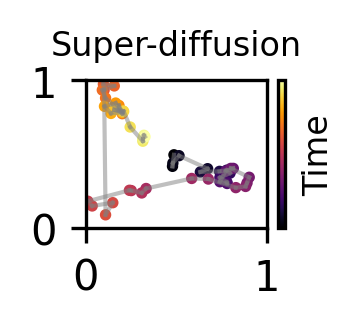

In [16]:
np.random.seed(222)
weight_mat = get_connection(dim=500)
scale_weight_mat = oscillatory_scalling(weight_mat, M=20, downscale_factor=0.5, upscale_factor=1.5)
steps = 200
downsamples = 50
traj_x = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
traj_y = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
#downsample the trajectory
traj_x = traj_x[::steps//downsamples]
traj_y = traj_y[::steps//downsamples]
#plot trajectory
fig, ax = plt.subplots(1, 1, figsize=(1.3,1.2), dpi=300)
for i in range(1,len(traj_x)):
    #if the distance between two points is smaller than dim//2, plot the link between two points
    if np.abs(traj_x[i]-traj_x[i-1])<dim/1.1 and np.abs(traj_y[i]-traj_y[i-1])<dim/1.1:
        ax.plot([traj_x[i-1], traj_x[i]], [traj_y[i-1], traj_y[i]], color='grey', linewidth=1, alpha=0.5)
scatters = ax.scatter(traj_x, traj_y, c=np.arange(len(traj_x)), cmap='inferno', s=3)
ax.set_xlim([0, dim])
ax.set_ylim([0, dim])
ax.set_xticks([0, dim])
ax.set_yticks([0, dim])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

#colorbar
cb = plt.colorbar(scatters)
cb.set_ticks([])
# cb.set_ticks([0, downsamples])
# cb.set_ticklabels([0, steps])
cb.set_label('Time', fontsize=8)
ax.set_title('Super-diffusion', fontsize=8)


plt.tight_layout()

plt.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig3_v2_oscillatory_scalling_single.pdf', dpi=300)


100%|██████████| 200/200 [00:00<00:00, 5094.22it/s]


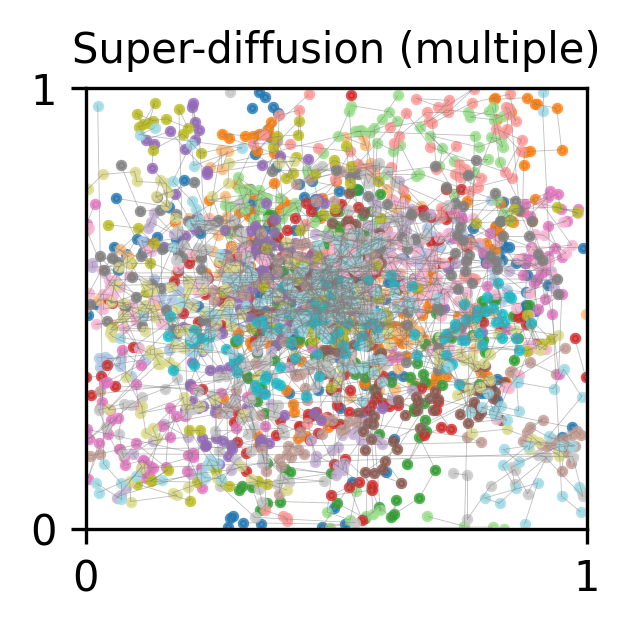

In [17]:
#simulating for N times and plot N trajectories
N=50
fig, ax = plt.subplots(1, 1, figsize=(2.2,2.2), dpi=300)
np.random.seed(0)
colors = plt.cm.tab20(np.linspace(0, 1, N))
for ind in range(N):
    weight_mat = get_connection(dim=500)
    scale_weight_mat = oscillatory_scalling(weight_mat, M=20, downscale_factor=0.5, upscale_factor=1.5)
    steps = 200
    downsamples = 50
    traj_x = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
    traj_y = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
    #downsample the trajectory
    traj_x = traj_x[::steps//downsamples]
    traj_y = traj_y[::steps//downsamples]
    for i in range(1,len(traj_x)):
        #if the distance between two points is smaller than dim//2, plot the link between two points
        if np.abs(traj_x[i]-traj_x[i-1])<dim/1.1 and np.abs(traj_y[i]-traj_y[i-1])<dim/1.1:
            ax.plot([traj_x[i-1], traj_x[i]], [traj_y[i-1], traj_y[i]], color='grey', linewidth=0.2, alpha=0.5)
    scatters = ax.scatter(traj_x, traj_y, s=3, color=colors[ind], alpha=0.8)    
    
ax.set_xlim([0, dim])
ax.set_ylim([0, dim])
ax.set_xticks([0, dim])
ax.set_yticks([0, dim])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])
ax.set_title('Super-diffusion (multiple)', fontsize=10)
plt.tight_layout()
plt.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig3_oscillatory_scalling_multiple.pdf', dpi=300)

## Section 4: generate diffusive pattern using quadratic eigenvalues

100%|██████████| 200/200 [00:00<00:00, 11290.79it/s]


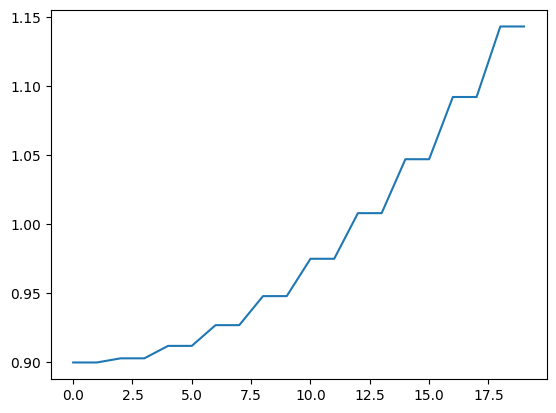

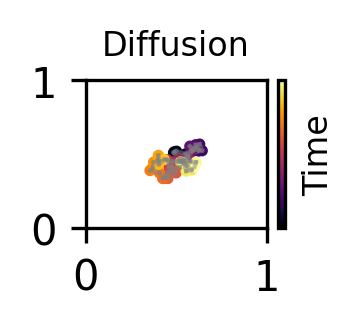

In [18]:
np.random.seed(222)
weight_mat = get_connection(dim=500)
scale_weight_mat = quadratic_scalling(weight_mat, M=20, down_value=0.9, up_value=1.2)
steps = 200
downsamples = 50
traj_x = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
traj_y = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
#downsample the trajectory
traj_x = traj_x[::steps//downsamples]
traj_y = traj_y[::steps//downsamples]
#plot trajectory
fig, ax = plt.subplots(1, 1, figsize=(1.3,1.2), dpi=300)
for i in range(1,len(traj_x)):
    #if the distance between two points is smaller than dim//2, plot the link between two points
    if np.abs(traj_x[i]-traj_x[i-1])<dim/1.1 and np.abs(traj_y[i]-traj_y[i-1])<dim/1.1:
        ax.plot([traj_x[i-1], traj_x[i]], [traj_y[i-1], traj_y[i]], color='grey', linewidth=1, alpha=0.5)
scatters = ax.scatter(traj_x, traj_y, c=np.arange(len(traj_x)), cmap='inferno', s=3)
ax.set_xlim([0, dim])
ax.set_ylim([0, dim])
ax.set_xticks([0, dim])
ax.set_yticks([0, dim])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

#colorbar
cb = plt.colorbar(scatters)
cb.set_ticks([])
cb.set_label('Time', fontsize=8)

ax.set_title('Diffusion', fontsize=8)

plt.tight_layout()
plt.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig3_quadratic_scalling_single.pdf', dpi=300)


100%|██████████| 200/200 [00:00<00:00, 8500.47it/s]


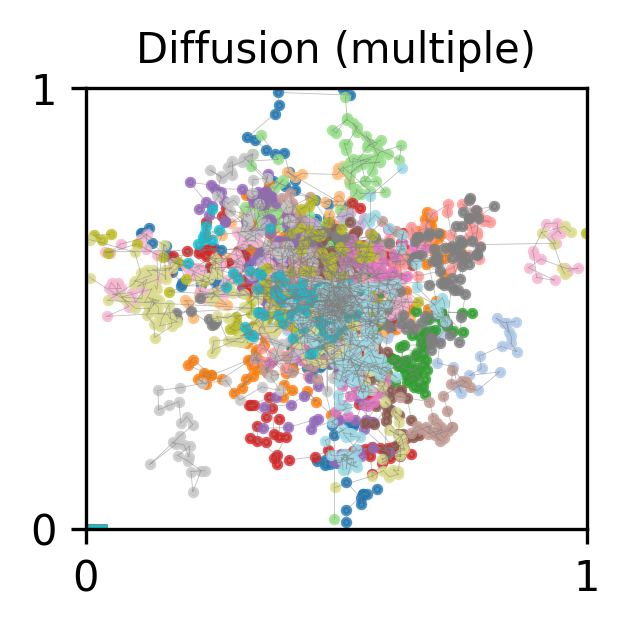

In [19]:
#simulating for 10 times and plot 10 trajectories
N=50
fig, ax = plt.subplots(1, 1, figsize=(2.2,2.2), dpi=300)
np.random.seed(0)
colors = plt.cm.tab20(np.linspace(0, 1, N))
for ind in range(N):
    weight_mat = get_connection(dim=500)
    scale_weight_mat = quadratic_scalling(weight_mat, M=20, down_value=0.9, up_value=1.2)
    steps = 200
    downsamples = 50
    traj_x = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
    traj_y = sampling_simulation(scale_weight_mat, dim, steps=steps, noise_level=0.1, visualization=False)
    #downsample the trajectory
    traj_x = traj_x[::steps//downsamples]
    traj_y = traj_y[::steps//downsamples]
    for i in range(1,len(traj_x)):
        #if the distance between two points is smaller than dim//2, plot the link between two points
        if np.abs(traj_x[i]-traj_x[i-1])<dim/1.1 and np.abs(traj_y[i]-traj_y[i-1])<dim/1.1:
            ax.plot([traj_x[i-1], traj_x[i]], [traj_y[i-1], traj_y[i]], color='grey', linewidth=0.2, alpha=0.5)
    scatters = ax.scatter(traj_x, traj_y, s=3, color=colors[ind], alpha=0.8)

ax.set_xlim([0, dim])
ax.set_ylim([0, dim])
ax.set_xticks([0, dim])
ax.set_yticks([0, dim])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])
ax.set_title('Diffusion (multiple)', fontsize=10)
plt.tight_layout()
plt.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig3_quadratic_scalling_multiple.pdf', dpi=300)

## Section 5: plot eigenvalue rescaling with two difference adaptation strength (reflect by the distance between two bumps)

In [12]:
from spectral_analysis_utils import constructTransmat, discrete_fourier_transform, theoretical_circulant_perturbation

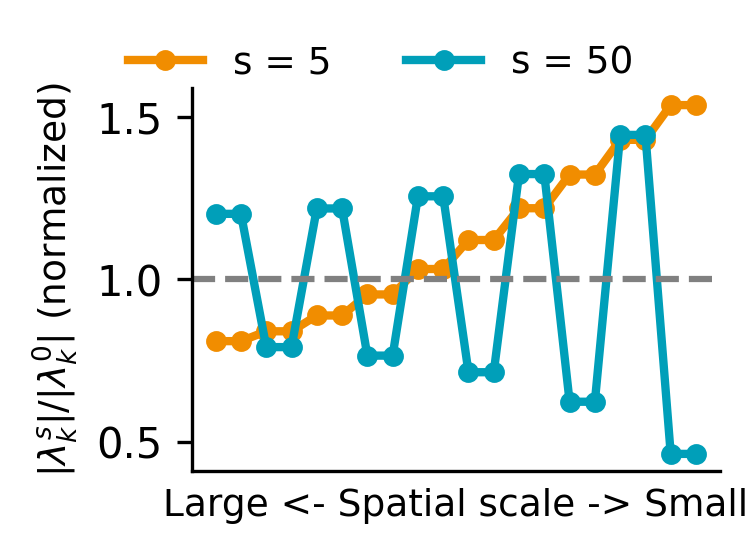

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(2.6,2), dpi=300)
labelsize =9
ticksize = 8


N = 100
var = 5
T = constructTransmat(N, 1, var)

epsilon = -0.2
evals_original = discrete_fourier_transform(T[0])
d_list = [2, 15]
colors = np.arange(N) / (N-1)

inds = np.argsort(np.abs(evals_original))[::-1]

colors = ['#F18D00', '#009FB9']
for d in [5, 50]:
    evals_perturbed_theoretical = evals_original + theoretical_circulant_perturbation(N, d, epsilon)
    ax.plot(np.arange(1, 21), (np.abs(evals_perturbed_theoretical) / np.abs(evals_original))[inds][1:21], "o-", label=f"s = {d}", 
             linewidth=2, markersize=4, color=colors.pop(0))

ax.legend(fontsize=labelsize, frameon=False, bbox_to_anchor=(0.9, 1.2), ncol=2)
# ax.set_xticks([0, 20], ["0\nLarge", "20\nSmall"], fontsize=labelsize)
ax.set_xticks([])
ax.axhline(1.0, linestyle="--", color="grey")
ax.set_xlabel("Large <- Spatial scale -> Small", fontsize=labelsize)
ax.set_ylabel(r"$|\lambda_{k}^{s}| / |\lambda^{0}_{k}|$ (normalized)", fontsize=labelsize)
#keep 1 decimal of yticks
ax.set_yticks([0.5,1,1.5])

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig3_eigenvalue_rescaling.pdf', dpi=300)
